In [23]:
import torch
import torchvision
from torch import nn
import time
import torch.nn.functional as F
from torch import optim
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [3]:
parser = argparse.ArgumentParser(description='nn_heisenberg_phase_discrimination')

parser.add_argument('--batch-size', type=int, default=100, metavar='N',help='input batch size for training (default: 100)')

parser.add_argument('--epochs', type=int, default=100, metavar='N',help='number of epochs to train (default: 100)')

parser.add_argument('--no-cuda', action='store_true', default=False,help='enables CUDA training')

parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=2,help='num class')

parser.add_argument('--mlp-dim', type=int, default=300, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.3, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')

parser.add_argument('--depth', type=int, default=3, help='_')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [48]:
#载入数据
data=[]
M_raw=[]

with h5py.File('four_phases_data/124_MT_20size_1T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw=np.array(M_raw)
print(data.shape)

sample_num, data_num = data.shape[1], data.shape[0]

data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

T = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T for j in range(sample_num)]

# Phase_label=np.array(Phase_label)

#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

data_all_beyondTc = data_all[:5*sample_num]+data_all[35*sample_num:]
data_all_closeTc = data_all[15*sample_num:25*sample_num]


print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_beyondTc), len(data_all_closeTc))



#载入数据
data=[]
M_raw_test=[]

with h5py.File('four_phases_data/124_MT_20size_2T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41): #15,25+1  
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_test.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_test=np.array(M_raw_test)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

T_test = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T_test for j in range(sample_num)]


#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_test=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]

data_all_test_beyondTc = data_all_test[:5*sample_num]+data_all_test[35*sample_num:]
data_all_test_closeTc = data_all_test[15*sample_num:25*sample_num]

print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_test_closeTc),len(data_all_test_beyondTc))


#载入数据
data=[]
M_raw_train_2=[]

with h5py.File('four_phases_data/124_MT_20size_1.5T_jiangede.hdf5', 'r') as f:

    for i in np.arange(1,41): # 15,25+1 
    
        dataset=f[str(i)+'.0K']
    
        data.append(dataset[:])

        M_raw_train_2.append(dataset[:].mean(axis=(0,2,3)).sum())

data=np.array(data)
M_raw_train_2=np.array(M_raw_train_2)
print(data.shape)

sample_num = data.shape[1]

data_num = data.shape[0]

data=data.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

T_train2 = np.linspace(1,40,data_num)
Tc=19

Phase_label=[]

[Phase_label.append(0) if i<=Tc else Phase_label.append(1)  for i in T_train2 for j in range(sample_num)]


#数据做变形,处于0到1之间,并将其和独热码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

#整合数据与标签
data_all_2=[[data_set[i], Phase_label[i]] for i in range(sample_num*data_num)]
data_all_2_beyondTc = data_all_2[:5*sample_num]+data_all_2[35*sample_num:]
data_all_2_closeTc = data_all_2[15*sample_num:25*sample_num]


print(data_set.shape)
print(Phase_label.shape)
print(len(data_all_2_beyondTc), len(data_all_2_closeTc))


(40, 500, 2, 20, 20)
torch.Size([20000, 800])
torch.Size([20000])
5000 5000
(40, 500, 2, 20, 20)
torch.Size([20000, 800])
torch.Size([20000])
5000 5000
(40, 500, 2, 20, 20)
torch.Size([20000, 800])
torch.Size([20000])
5000 5000


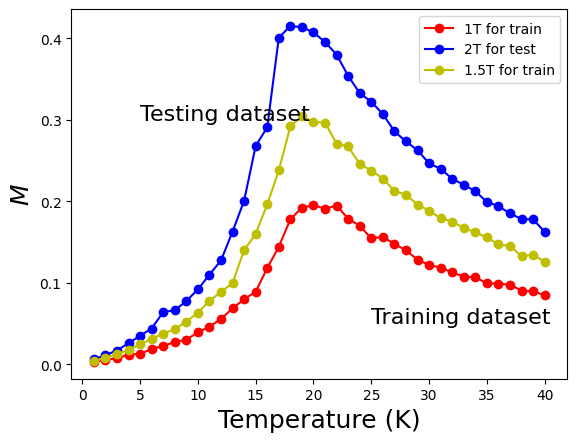

In [5]:

plt.plot(T,M_raw,'ro-',label='1T for train')
plt.plot(T_test,M_raw_test,'bo-',label='2T for test')
plt.plot(T_train2,M_raw_train_2,'yo-',label='1.5T for train')

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)

plt.text(25,0.05,'Training dataset',fontsize=16)
plt.text(5,0.30,'Testing dataset',fontsize=16)

plt.legend()
plt.show()

In [6]:
class Heisenberg_dataset:
    def __init__(self, x_list):
        """ initialize the class instance
        Args:
            x_list: data with list type
        Returns:
            None
        """
        if not isinstance(x_list, list):
            raise ValueError("input x_list is not a list type")
        self.data = x_list
        print("intialize success")
    
    def __getitem__(self, idx):
        # print("__getitem__ is called")
        return self.data[idx]
    
    def __len__(self):
        # print("__len__ is called")
        return len(self.data)

data_train = Heisenberg_dataset(data_all_closeTc+data_all_2_closeTc)#+data_all_test_closeTc
data_test = Heisenberg_dataset(data_all_test)#data_all_beyondTc+data_all_2_beyondTc+

intialize success
intialize success


In [7]:
train_loader = DataLoader(data_train, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size = args.batch_size, shuffle=True )

In [8]:
len(test_loader)

200

In [51]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, v_dim=200,h_dim=500, class_num=2,dropout=0.1, depth=2):
        # initialise parent pytorch class
        super().__init__()
        
        # self.model = nn.Sequential(
            
        #     nn.Linear(v_dim, h_dim),
            
        #     # nn.LeakyReLU(),  
        #     nn.ReLU(),         
        #     # nn.LayerNorm(h_dim),
        #     # nn.BatchNorm1d(h_dim),
        #     nn.Dropout(p=dropout),

        #     nn.Linear(h_dim, h_dim),
        #     # nn.Dropout(p=dropout),
        #     # # nn.LeakyReLU(),  
        #     nn.ReLU(),           
        #     # nn.LayerNorm(h_dim),
        #     # # nn.BatchNorm1d(h_dim),
        #     nn.Dropout(p=dropout),

            
        #     nn.Linear(h_dim, class_num),
        #     # nn.Sigmoid()
        #     # nn.Softmax()
        # )
        layers = [nn.Linear(v_dim, h_dim), nn.ReLU(), nn.Dropout(p=dropout),]

        for _ in range(depth):
            layers.append(nn.Linear(h_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))

            layers.append(nn.ReLU())
            # layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.Dropout(p=dropout))

        layers.append(nn.Linear(h_dim, class_num))

        # self.model = nn.Sequential(*layers)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):

        # # simply run model
        # return self.model(x)

        for layer in self.model:
            x = layer(x)

        return x

    

def Train_model(model, optimizer, data_loader, loss_history,epoch):
    model.train()
    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)

    The_loss=0

    for data, target in data_loader:

        
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)

        loss_f = nn.CrossEntropyLoss()
        loss = loss_f(model.forward(data), target)

        # outputs=F.gumbel_softmax(model(data), tau=10, hard=False,dim=-1)
        # outputs = torch.log(outputs)
        # loss_f = nn.NLLLoss()
        
        # loss = loss_f(outputs,target)


        The_loss+=loss.detach().item()

        loss.backward()
        optimizer.step()


    loss_history.append(The_loss/len(data_loader))#loss.item()

    if epoch % 10==0 or epoch<=5:
        print('Epoch {}: Average train loss : {:.5f}'.format(epoch,The_loss/len(data_loader)))

def evaluate(model, data_loader, loss_history,Accuracy_rate,epoch):
    model.eval()

    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        
        for data, target in data_loader:

            data=data.to(device)
            target=target.to(device)

            ###softmax+log+nllloss
            # FN_1 = nn.LogSoftmax(dim=-1)
            # loss_f = nn.NLLLoss()
            # loss = loss_f(FN_1(model(data)),target)

            ##gumbel_softmax+log+nllloss
            # outputs=F.gumbel_softmax(model(data), tau=10, hard=False,dim=-1)
            # outputs = torch.log(outputs)
            # loss_f = nn.NLLLoss()
            # loss = loss_f(outputs,target)

            # _, pred = torch.max(output, dim=0)

            ##CrossEntropyLoss
            loss_f = nn.CrossEntropyLoss()
            loss = loss_f(model.forward(data), target)

            total_loss += loss.item()
            # correct_samples += pred.eq(target).sum()
            ###
            predicted = nn.Softmax(dim=-1)(model.forward(data)).argmax(dim=-1)
            # predicted=F.gumbel_softmax(model.forward(data), tau=1, hard=True,dim=-1).argmax(dim=-1)

            # total += target.size(0)
            correct_samples += predicted.eq(target).sum().item()


    avg_loss = total_loss / len(data_loader)#total_samples
    loss_history.append(avg_loss)
    Accuracy = (100.0 * correct_samples / total_samples)
    Accuracy_rate.append(Accuracy)

    if epoch % 10 ==0 or epoch<=5:

        print('Epoch {}: '.format(epoch)+'Average test loss: ' + '{:.5f}'.format(avg_loss) +
            '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
            '{:5}'.format(total_samples) + ' (' +
            '{:4.2f}'.format(Accuracy) + '%)\n')


In [52]:
%%time


model_D = Discriminator(v_dim=args.channels*args.imgage_size**2, h_dim=args.mlp_dim, class_num=args.num_class,dropout=args.dropout_rate,depth=args.depth)#,args.mlp_dim

model_D.to(device)
optimizer = optim.Adam(model_D.parameters(), lr=args.learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range(1,  100+ 1):#args.epochs
    # print('Epoch:', epoch)
    Train_model(model_D, optimizer, train_loader, train_loss_history,epoch)
    evaluate(model_D, test_loader, test_loss_history,Accuracy_rate,epoch)

Epoch 1: Average train loss : 0.59619
Epoch 1: Average test loss: 0.23434  Accuracy:18604/20000 (93.02%)

Epoch 2: Average train loss : 0.40624
Epoch 2: Average test loss: 0.17614  Accuracy:18809/20000 (94.05%)

Epoch 3: Average train loss : 0.36950
Epoch 3: Average test loss: 0.19680  Accuracy:18678/20000 (93.39%)

Epoch 4: Average train loss : 0.34529
Epoch 4: Average test loss: 0.20932  Accuracy:18665/20000 (93.33%)

Epoch 5: Average train loss : 0.33682
Epoch 5: Average test loss: 0.19584  Accuracy:18706/20000 (93.53%)

Epoch 10: Average train loss : 0.25711
Epoch 10: Average test loss: 0.22999  Accuracy:18612/20000 (93.06%)

Epoch 20: Average train loss : 0.12006
Epoch 20: Average test loss: 0.30710  Accuracy:18698/20000 (93.49%)

Epoch 30: Average train loss : 0.06538
Epoch 30: Average test loss: 0.38637  Accuracy:18689/20000 (93.44%)

Epoch 40: Average train loss : 0.03927
Epoch 40: Average test loss: 0.45321  Accuracy:18631/20000 (93.16%)

Epoch 50: Average train loss : 0.03718

In [ ]:
# model_D
# for i,(name, parameter) in enumerate(model_D.named_parameters()):
#     print(name, ':', parameter.size())

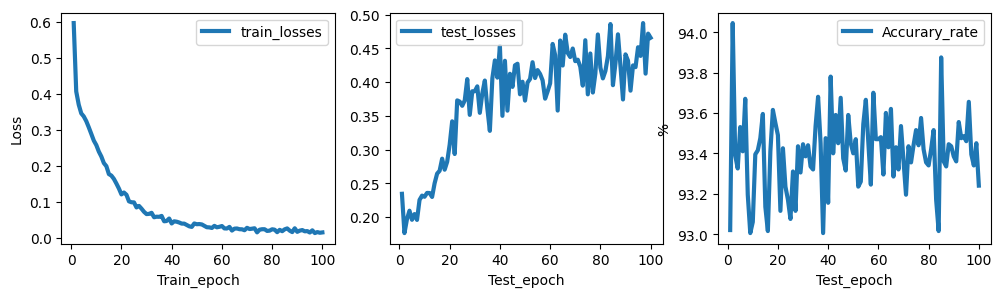

In [53]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()

In [54]:
output_label = np.zeros(len(T_test))
model_D.eval()
for i in range(0,sample_num*len(T_test), sample_num):
    A_test=data_all_test[i:i+500]
    label_all=0
    with torch.no_grad():
        for img ,label in A_test:
            img=img.cuda()
            img=img.view(-1,800)
            A=nn.Softmax(dim=-1)(model_D(img)).argmax(dim=-1)
            label_all+=A
            # print(A)
        print('{} K The number of PM by model is {}'.format((int(i/500+1)), label_all.cpu().numpy()))
        output_label[(int(i/500))] = label_all.cpu().numpy()/sample_num



1 K The number of PM by model is [0]
2 K The number of PM by model is [0]
3 K The number of PM by model is [0]
4 K The number of PM by model is [0]
5 K The number of PM by model is [0]
6 K The number of PM by model is [0]
7 K The number of PM by model is [0]
8 K The number of PM by model is [0]
9 K The number of PM by model is [0]
10 K The number of PM by model is [0]
11 K The number of PM by model is [0]
12 K The number of PM by model is [0]
13 K The number of PM by model is [0]
14 K The number of PM by model is [0]
15 K The number of PM by model is [0]
16 K The number of PM by model is [0]
17 K The number of PM by model is [353]
18 K The number of PM by model is [460]
19 K The number of PM by model is [447]
20 K The number of PM by model is [475]
21 K The number of PM by model is [496]
22 K The number of PM by model is [489]
23 K The number of PM by model is [491]
24 K The number of PM by model is [495]
25 K The number of PM by model is [489]
26 K The number of PM by model is [496]
2

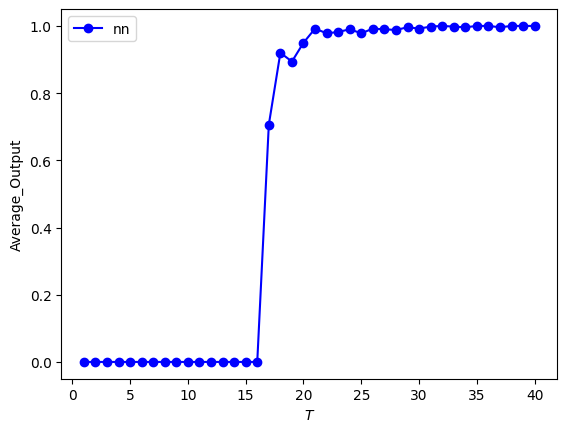

In [55]:
plt.plot(T_test,output_label, 'bo-',label='nn')
plt.ylabel('Average_Output')
plt.xlabel(r'$T$')
plt.legend()
plt.show()

In [42]:
T_test=18
i=np.random.randint((T_test-1)*500, T_test*500)
print(i)
img, label=data_all_test[i]
print(label)
img=img.view(-1,800).to(device)
nn.Softmax(dim=-1)(model_D(img))
# F.gumbel_softmax(model_D(img), tau=1, hard=False)



8962
tensor(0)


tensor([[8.0442e-05, 9.9992e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [95]:
logits = torch.tensor([0.4,0.8])
# Sample soft categorical using reparametrization trick:
F.gumbel_softmax(logits, tau=1, hard=False)
# Sample hard categorical using "Straight-through" trick:
F.gumbel_softmax(logits, tau=1, hard=True)#.shape

tensor([0., 1.])

In [ ]:
nllloss = nn.NLLLoss()
predict = torch.Tensor([[2, 3, 1]])
label = torch.tensor([1])
nllloss(predict, label)


In [146]:
m = nn.LogSoftmax(dim=-1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(4, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4, 2])
output = loss(m(input), target)
# output.backward()
# # 2D loss example (used, for example, with image inputs)
# N, C = 5, 4
# loss = nn.NLLLoss()
# # input is of size N x C x height x width
# data = torch.randn(N, 16, 10, 10)
# conv = nn.Conv2d(16, C, (3, 3))
# m = nn.LogSoftmax(dim=1)
# # each element in target has to have 0 <= value < C
# target = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
# output = loss(m(conv(data)), target)
# output.backward()

In [144]:
m(input)

tensor([[-1.7238, -2.5763, -2.5332, -1.6730, -0.7372],
        [-1.2156, -1.4924, -1.0382, -2.1828, -4.4356],
        [-3.3951, -1.7017, -1.2784, -0.7973, -2.8990]],
       grad_fn=<LogSoftmaxBackward0>)

In [160]:
torch.log(torch.tensor(4))

tensor(1.3863)

In [27]:
x=torch.tensor([[1.,2.],[3.,4.]])
x.mean(axis=0)

tensor([2., 3.])